# 強化学習

転移学習＋強化学習はいけるのでは？
違うバックグラウンドの知識を持つエージェントが別のドメインに飛ばされた時どのような行動を見せるのか

In [1]:
from __future__ import division
import numpy as np
import random
import warnings
import math
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm

## 多腕バンディット問題

### greedy algorithm

In [2]:
#引数 -> dict {方策名(番号?), [プレイした回数,報酬の和]}
#return -> 選択した方策
def greedy(status_dict, n):
    dict_keys = status_dict.keys()
    play_num_ary = np.array([status_dict[key][0] for key in dict_keys])
    if np.min(play_num_ary) < n:
        return dict_keys[np.argmin(play_num_ary)]
    else:
        mu_lst = np.array([status_dict[key][1] / status_dict[key][0] for key in dict_keys])
        return dict_keys[np.argmax(mu_lst)]

### ε-greedy algorithm

In [3]:
#引数 -> dict {方策名(番号?), [プレイした回数,報酬の和]}
#return -> 選択した方策
def eps_greedy(status_dict, eps):
    dict_keys = status_dict.keys()
    play_num_ary = np.array([status_dict[key][0] for key in dict_keys])
    if np.min(play_num_ary) == 0:
        return dict_keys[np.argmin(play_num_ary)]
    if np.random.rand() <= eps:
        return random.choice(np.array(dict_keys))
    else:
        mu_lst = np.array([status_dict[key][1] / status_dict[key][0] for key in dict_keys])
        return dict_keys[np.argmax(mu_lst)]

### 楽観的初期値法(optimistic initial values)

In [4]:
#引数 -> dict {方策名(番号?), [プレイした回数,報酬の和]}, r_sup : 各腕からの報酬の上界
#return -> 選択した方策
def optimistic_init_val(status_dict, r_sup):
    K = len(status_dict)
    dict_keys = status_dict.keys()
    mu_lst = np.array([(status_dict[key][1] + K * r_sup) / (status_dict[key][0] + K) for key in dict_keys])
    return dict_keys[np.argmax(mu_lst)]

### UCB1 (Upper Confidence Bound) algorithm

In [5]:
#引数 -> dict {方策名(番号?), [プレイした回数,報酬の和]}, R : はらいもどしがくん最大値と最小値の差
#return -> 選択した方策
def UBC1(status_dict, R):
    dict_keys = status_dict.keys()
    play_num_ary = np.array([status_dict[key][0] for key in dict_keys])
    if np.min(play_num_ary) == 0:
        return dict_keys[np.argmin(play_num_ary)]
    mu_lst = np.array([status_dict[key][1] / status_dict[key][0] for key in dict_keys])
    U_bunshi = 2 * math.log(np.sum(play_num_ary))
    U_lst = np.array([R * math.sqrt(U_bunshi / status_dict[key][0]) for key in dict_keys])
    return dict_keys[np.argmax(mu_lst+U_lst)]  

### スロットの定義

In [6]:
#結果のプロットはmatplotlibのstackplotでできそう
#prob_reward_lst -> [[0.8, 8], [0.2, 1]]
class slot:
    def __init__(self, name, prob_reward_lst):
        self.name = name
        self.prob_reward_lst = prob_reward_lst
        self.played_num = 0
        self.total_reward = 0
        self.convert_pr_dict()
        
    def convert_pr_dict(self):
        start = 0
        self.pr_range = []
        for ele in self.prob_reward_lst:
            self.pr_range.append([[start, start+ele[0]], ele[1]])
            start += ele[0]
        if not start == 1: #もし確率が1出なかったらエラー
            warnings.warn('Illegal reward function!!!')
    
    def turn(self):
        self.played_num += 1
        prob = np.random.rand()
        for ele in self.pr_range:
            #線形探索じゃなく2分探索とかしてもいいけどn自体が大きくないから無視
            #境界だったらlistの先頭に近い方を優先 -> どっちかをランダム選択の方がいい？
            if (ele[0][0] <= prob) and (prob <= ele[0][1]):
                self.total_reward += ele[1]
                return ele[1]
        return None
    
    def get_name(self):
        return self.name
    
    def get_status_dict(self):
        return {self.name : [self.played_num, self.total_reward]}

### ゲームの定義

In [7]:
R = 20
PLAY_NUM = 10000
TIME_STEP = 100
# arm_a  = slot("a", [[0.3, R], [0.7, 0]])
# arm_b  = slot("b", [[0.59, R], [0.41, 0]])
# arm_c  = slot("c", [[0.52, R], [0.48, 0]])
# arm_d  = slot("d", [[0.55, R], [0.45, 0]])

# arms_status_dict = {"a":[0,0],"b":[0,0],"c":[0,0],"d":[0,0]}

selected_arms_percentage = [] #length:play_num
average_rewards = [] #length:play_num

arm_a  = slot("a", [[0.2, R], [0.8, 0]])
arm_b  = slot("b", [[0.3, R], [0.7, 0]])
arm_c  = slot("c", [[0.4, R], [0.6, 0]])
arm_d  = slot("d", [[0.5, R], [0.5, 0]])

for i in tqdm.tqdm(range(PLAY_NUM)):
    selected_arms = {"a":0, "b":0, "c":0, "d":0}
    arms_status_dict = {"a":[0,0],"b":[0,0],"c":[0,0],"d":[0,0]}
    average_reward_per_time = 0.
    for j in xrange(TIME_STEP):
        selected_arm = optimistic_init_val(arms_status_dict, R) #多腕バンディットアルゴリズム
        if selected_arm == 'a':
            reward =  arm_a.turn()
            arms_status_dict.update(arm_a.get_status_dict())

        elif selected_arm == 'b':
            reward =  arm_b.turn()
            arms_status_dict.update(arm_b.get_status_dict())

        elif selected_arm == 'c':
            reward =  arm_c.turn()
            arms_status_dict.update(arm_c.get_status_dict())

        elif selected_arm == 'd':
            reward =  arm_d.turn() 
            arms_status_dict.update(arm_d.get_status_dict())

        selected_arms[selected_arm] = selected_arms[selected_arm] + 1
        average_reward_per_time += reward
        
    average_reward_per_time /= TIME_STEP
    average_rewards.append(average_reward_per_time)
    selected_arms_percentage.append(np.array([selected_arms["a"], selected_arms["b"], selected_arms["c"], selected_arms["d"]]) / np. sum(np.array(selected_arms.values())))

100%|██████████| 10000/10000 [00:07<00:00, 1255.35it/s]


### 結果の描画

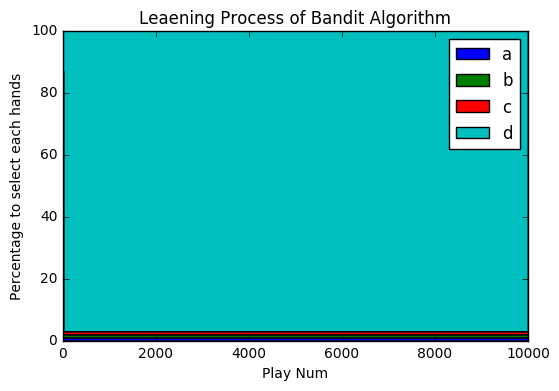

In [8]:
selected_arms_percentage = np.array(selected_arms_percentage) * 100 #パーセントにキャスト
x = np.arange(PLAY_NUM)
# スタックプロット
fig, ax = plt.subplots()
ax.stackplot(x, selected_arms_percentage.T, labels=["a","b","c","d"])
plt.legend()
plt.title("Leaening Process of Bandit Algorithm")
plt.xlabel("Play Num")
plt.ylabel("Percentage to select each hands")
plt.show()

## 割引報酬和

In [ ]:
class finite_MDP: